In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement_ref = Base.classes.measurement
station_ref = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#Find the last date in the database
last_date = session.query(measurement_ref.date).order_by(measurement_ref.date.desc()).first()
last_date[0]

'2017-08-23'

In [11]:
# Calculate the date 1 year ago (i.e., 12 months)

query_date = dt.date(2017, 8, 23) - dt.timedelta(weeks=52)
query_date

datetime.date(2016, 8, 24)

In [12]:
# Query for date and precipitation

last_12_months = session.query(measurement_ref.date, measurement_ref.prcp).\
    filter(measurement_ref.date >= query_date).all()

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column

precip_df = pd.DataFrame(last_12_months)
precip_df = precip_df.set_index("date")
precip_df

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [14]:
# Sort the dataframe by date
precip_df = precip_df.sort_values("date")
precip_df

,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


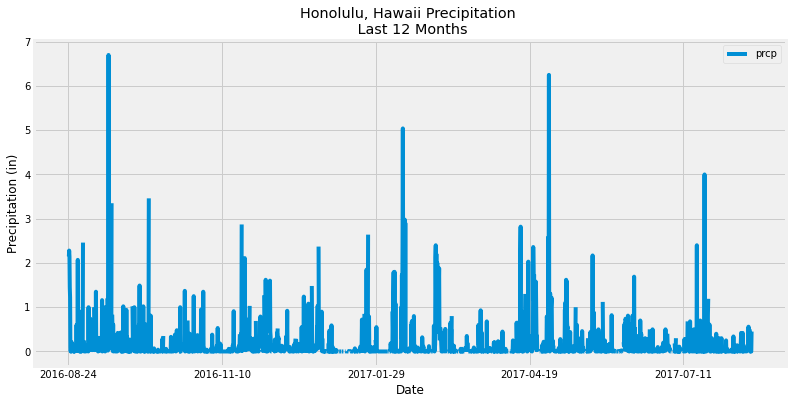

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Precipitation (in)")
plt.title("Honolulu, Hawaii Precipitation \n Last 12 Months")
plt.savefig("images/hon_hawaii_precip_timeseries.jpeg")

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data

summary_precip_df = precip_df.groupby("date").agg({"prcp": ["mean", "median", "var", "std", "sem"]})
summary_precip_df

prcp                                     
                mean median       var       std       sem
date                                                     
2016-08-24  1.555000  1.800  0.706510  0.840541  0.343150
2016-08-25  0.077143  0.080  0.005157  0.071813  0.027143
2016-08-26  0.016667  0.015  0.000267  0.016330  0.006667
2016-08-27  0.064000  0.020  0.006680  0.081731  0.036551
2016-08-28  0.516667  0.140  0.620427  0.787672  0.321566
...              ...    ...       ...       ...       ...
2017-08-19  0.030000  0.000  0.002700  0.051962  0.030000
2017-08-20  0.005000  0.005  0.000050  0.007071  0.005000
2017-08-21  0.193333  0.020  0.100933  0.317700  0.183424
2017-08-22  0.166667  0.000  0.083333  0.288675  0.166667
2017-08-23  0.132500  0.040  0.046225  0.215000  0.107500

[365 rows x 5 columns]

In [17]:
# Design a query to show how many stations are available in this dataset?
count_stations = session.query(func.count(measurement_ref.station)).group_by(measurement_ref.station).count()
print(f"There are {count_stations} unique station IDs.")

There are 9 unique station IDs.


In [18]:
count_total_stations_occur = session.query(func.count(measurement_ref.station))
print(f"There are {count_total_stations_occur[0][0]} total occurances of station IDs.")

There are 19550 total occurances of station IDs.


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?

grouped_station_count = session.query(func.count(measurement_ref.station)).group_by(measurement_ref.station).all()
grouped_station_count

[(1979), (2709), (2202), (2612), (1372), (511), (2772), (2724), (2669)]

In [20]:
# List the stations and the counts in descending order.
ordered_stations = session.query(measurement_ref.station, func.count(measurement_ref.station)).order_by(func.count(measurement_ref.station).desc()).group_by(measurement_ref.station).all()

station_list = []

for station in ordered_stations:
    print(station[0], station[1])

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded
min_temp = session.query(func.min(measurement_ref.tobs)).all()

for temp in min_temp:
    print(f"The lowest temperature recorded was {temp[0]}.")

The lowest temperature recorded was 53.0.


In [22]:
# highest temperature recorded, and average temperature of the most active station?
max_temp = session.query(func.max(measurement_ref.tobs)).all()

for temp in max_temp:
    print(f"The highest temperature recorded was {temp[0]}.")

The highest temperature recorded was 87.0.


In [23]:
# Choose the station with the highest number of temperature observations.
all_temp_records = session.query(measurement_ref.station, func.count(measurement_ref.tobs)).\
                    order_by(func.count(measurement_ref.tobs).desc()).group_by(measurement_ref.station).all()

all_temp_records

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
most_temp_recs = session.query(measurement_ref.date, measurement_ref.tobs).filter(measurement_ref.station == 'USC00519281').all()
most_temp_recs

[('2010-01-01', 70.0),
 ('2010-01-02', 62.0),
 ('2010-01-03', 74.0),
 ('2010-01-04', 75.0),
 ('2010-01-05', 74.0),
 ('2010-01-06', 76.0),
 ('2010-01-07', 69.0),
 ('2010-01-08', 66.0),
 ('2010-01-09', 70.0),
 ('2010-01-10', 75.0),
 ('2010-01-11', 64.0),
 ('2010-01-12', 60.0),
 ('2010-01-13', 61.0),
 ('2010-01-14', 68.0),
 ('2010-01-15', 64.0),
 ('2010-01-16', 66.0),
 ('2010-01-17', 67.0),
 ('2010-01-18', 70.0),
 ('2010-01-19', 67.0),
 ('2010-01-20', 67.0),
 ('2010-01-21', 69.0),
 ('2010-01-22', 60.0),
 ('2010-01-23', 75.0),
 ('2010-01-24', 75.0),
 ('2010-01-25', 65.0),
 ('2010-01-26', 75.0),
 ('2010-01-27', 69.0),
 ('2010-01-28', 67.0),
 ('2010-01-29', 66.0),
 ('2010-01-30', 69.0),
 ('2010-01-31', 72.0),
 ('2010-02-01', 67.0),
 ('2010-02-02', 65.0),
 ('2010-02-03', 64.0),
 ('2010-02-04', 67.0),
 ('2010-02-05', 67.0),
 ('2010-02-06', 68.0),
 ('2010-02-07', 69.0),
 ('2010-02-08', 66.0),
 ('2010-02-09', 69.0),
 ('2010-02-10', 61.0),
 ('2010-02-11', 71.0),
 ('2010-02-12', 70.0),
 ('2010-02-

In [25]:
station_USC00519281_df = pd.DataFrame(most_temp_recs)

In [26]:
station_USC00519281_df = station_USC00519281_df.set_index("date")

In [27]:
station_USC00519281_df

,tobs
date,
2010-01-01,70.0
2010-01-02,62.0
2010-01-03,74.0
2010-01-04,75.0
2010-01-05,74.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


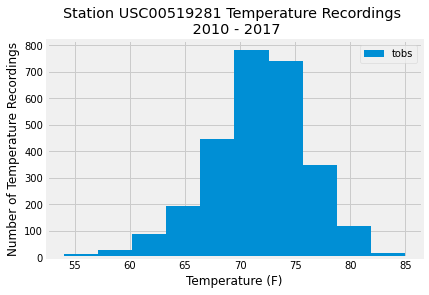

In [28]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_USC00519281_df.plot(kind="hist")
plt.title("Station USC00519281 Temperature Recordings \n 2010 - 2017")
plt.xlabel("Temperature (F)")
plt.ylabel("Number of Temperature Recordings")
plt.savefig("images/station_USC00519281_temp_recordings.jpeg")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
